## Introduction

This in-class example demonstrates how to handle time trend, seasonality, and autoregressive processes.

What you need to know:
- Statsmodels and pandas modules in python
- Theoretical concepts on time series regression model

The list of [references](#References) for detailed concepts and techniques used in this exerise.
***

## Content
- [Time trend and seasonality](#Time-Trend-and-Seasonality)
- [Autoregressive process of order 1](#Autoregressive-Process-of-Order-1)
- [Complete model with other exogenous regressors](#Complete-Model-with-other-Exogenous-Regressors)
- [References](#References)


***
## Data Description

The data set is contained in a comma-separated value (csv) file named ```CDN_hprice.csv``` with column headers. 

The data is a set of quarterly observations on a housing price index and other relevant variables in Canada for 1976 through 2019.

This data set is obtained from [Federal Reserve Bank of Dallas's International House Price Database](https://www.dallasfed.org/institute/houseprice).

Description of the data is as follow:

| Variable name | Variable description |
| -- | ----------- |
| Year      | Year |
| Quarter   | Quarter |
| RHPI      | House Price Index (real) |
| RPDI      | Personal disposable income (real) |
| logRHPI   | log(RHPI)   |
| logRPDI   | log(RPDI)   |
| UE        | Unemployment rate (in percentage points) |
| CPI       | Consumer Price Index |
| TB10_rt   | 10-year treasury bond rate (nominal) |
| RTB10_rt  | 10-year Treasury Bond rate (real) |


***
## Load the required modules

In [160]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot

***
## Import the data set

#### Load the data set into Python

In [161]:
hprice = pd.read_csv("CDN_hprice.csv")
hprice.head()

,Year,Quarter,RHPI,RPDI,RTB10_rt,CPI,TB10_rt,UE,logRHPI,logRPDI
0,1976,Q1,58.98,74.11,0.835,24.414,9.327,6.867,4.0772,4.3056
1,1976,Q2,59.81,75.93,2.535,24.783,9.270,7.167,4.0912,4.3298
2,1976,Q3,58.82,73.23,2.885,25.125,8.937,7.367,4.0745,4.2936
3,1976,Q4,57.63,75.18,1.919,25.652,8.610,7.733,4.0540,4.3199
4,1977,Q1,55.78,74.07,0.943,26.310,8.783,7.867,4.0214,4.3050


***
## Data preparation

#### 1.1 Sort the data in ascending order by year and quarter

In [162]:
hprice = hprice.sort_values(by = ["Year","Quarter"])
print(hprice.head())

   Year Quarter   RHPI   RPDI  RTB10_rt     CPI  TB10_rt     UE  logRHPI  \
0  1976      Q1  58.98  74.11     0.835  24.414    9.327  6.867   4.0772   
1  1976      Q2  59.81  75.93     2.535  24.783    9.270  7.167   4.0912   
2  1976      Q3  58.82  73.23     2.885  25.125    8.937  7.367   4.0745   
3  1976      Q4  57.63  75.18     1.919  25.652    8.610  7.733   4.0540   
4  1977      Q1  55.78  74.07     0.943  26.310    8.783  7.867   4.0214   

   logRPDI  
0   4.3056  
1   4.3298  
2   4.2936  
3   4.3199  
4   4.3050  


#### 1.2 Generate time index

Create new variable ```t``` such that $t=0$ in the first period. 

Note that we have repeated year and quarters. You can create the the required index by:
1. Sorting the observations in ascending order, as you are asked to do in (1.1)
2. Add a new column using the ```df.index``` method, where ```df``` is the name of the pandas dataframe

In [163]:
hprice["t"] = hprice.index

print(hprice.head())

   Year Quarter   RHPI   RPDI  RTB10_rt     CPI  TB10_rt     UE  logRHPI  \
0  1976      Q1  58.98  74.11     0.835  24.414    9.327  6.867   4.0772   
1  1976      Q2  59.81  75.93     2.535  24.783    9.270  7.167   4.0912   
2  1976      Q3  58.82  73.23     2.885  25.125    8.937  7.367   4.0745   
3  1976      Q4  57.63  75.18     1.919  25.652    8.610  7.733   4.0540   
4  1977      Q1  55.78  74.07     0.943  26.310    8.783  7.867   4.0214   

   logRPDI  t  
0   4.3056  0  
1   4.3298  1  
2   4.2936  2  
3   4.3199  3  
4   4.3050  4  


#### 1.3 Generate lag variable

Here we create lag variables with a lag of **4** period. That is, in quarterly frequency, the lag variable is in the *same* quarter but *different* year.

Create a new column in the date set named ```logRHPI_4```, such that $\text{logRHPI}\_4 = \log(\textit{RHPI}_{t-4})$ 

In [164]:
hprice["logRHPI_4"] = hprice["logRHPI"].shift(4)
print(hprice.head(6))

   Year Quarter   RHPI   RPDI  RTB10_rt     CPI  TB10_rt     UE  logRHPI  \
0  1976      Q1  58.98  74.11     0.835  24.414    9.327  6.867   4.0772   
1  1976      Q2  59.81  75.93     2.535  24.783    9.270  7.167   4.0912   
2  1976      Q3  58.82  73.23     2.885  25.125    8.937  7.367   4.0745   
3  1976      Q4  57.63  75.18     1.919  25.652    8.610  7.733   4.0540   
4  1977      Q1  55.78  74.07     0.943  26.310    8.783  7.867   4.0214   
5  1977      Q2  55.20  75.11     0.238  26.863    8.653  8.233   4.0110   

   logRPDI  t  logRHPI_4  
0   4.3056  0        NaN  
1   4.3298  1        NaN  
2   4.2936  2        NaN  
3   4.3199  3        NaN  
4   4.3050  4     4.0772  
5   4.3190  5     4.0912  


Create a new column in the date set named ```logRPDI_4```, such that $\text{logRPDI}\_4 = \log(\textit{RPDI}_{t-4})$ 

In [165]:
hprice["logRHPI_4"] = hprice["logRPDI"].shift(4)
print(hprice.head(6))

   Year Quarter   RHPI   RPDI  RTB10_rt     CPI  TB10_rt     UE  logRHPI  \
0  1976      Q1  58.98  74.11     0.835  24.414    9.327  6.867   4.0772   
1  1976      Q2  59.81  75.93     2.535  24.783    9.270  7.167   4.0912   
2  1976      Q3  58.82  73.23     2.885  25.125    8.937  7.367   4.0745   
3  1976      Q4  57.63  75.18     1.919  25.652    8.610  7.733   4.0540   
4  1977      Q1  55.78  74.07     0.943  26.310    8.783  7.867   4.0214   
5  1977      Q2  55.20  75.11     0.238  26.863    8.653  8.233   4.0110   

   logRPDI  t  logRHPI_4  
0   4.3056  0        NaN  
1   4.3298  1        NaN  
2   4.2936  2        NaN  
3   4.3199  3        NaN  
4   4.3050  4     4.3056  
5   4.3190  5     4.3298  


#### 1.4 Generate "*first-differencing*" variables

It is also known as the year-over-year difference, because we take the difference between now and 4 quarters (a year) ago. 

E.g. we are calulating the change from 2018 Q1 to 2019 Q1. 

Create a new column named ```gRHPI```, such that $\text{gRHPI} = \Delta \log(\textit{RHPI}_t) = \log(\textit{RHPI}_t) - \log(\textit{RHPI}_{t-4})$

In [166]:
hprice["gRHPI"] = hprice["logRHPI"] - hprice["logRHPI_4"]
print(hprice.head(6))

   Year Quarter   RHPI   RPDI  RTB10_rt     CPI  TB10_rt     UE  logRHPI  \
0  1976      Q1  58.98  74.11     0.835  24.414    9.327  6.867   4.0772   
1  1976      Q2  59.81  75.93     2.535  24.783    9.270  7.167   4.0912   
2  1976      Q3  58.82  73.23     2.885  25.125    8.937  7.367   4.0745   
3  1976      Q4  57.63  75.18     1.919  25.652    8.610  7.733   4.0540   
4  1977      Q1  55.78  74.07     0.943  26.310    8.783  7.867   4.0214   
5  1977      Q2  55.20  75.11     0.238  26.863    8.653  8.233   4.0110   

   logRPDI  t  logRHPI_4   gRHPI  
0   4.3056  0        NaN     NaN  
1   4.3298  1        NaN     NaN  
2   4.2936  2        NaN     NaN  
3   4.3199  3        NaN     NaN  
4   4.3050  4     4.3056 -0.2842  
5   4.3190  5     4.3298 -0.3188  


#### 1.5 Plot the time series for log(RHPI) and growth rate of RHPI

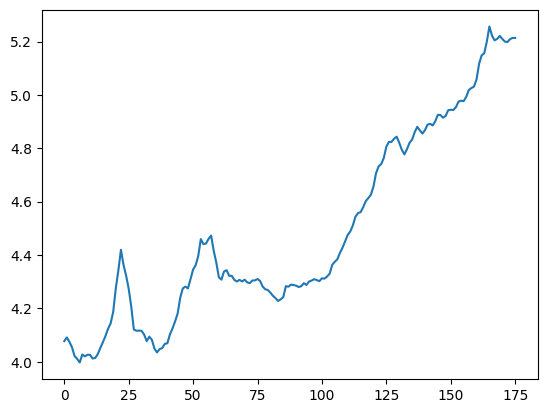

In [167]:
matplotlib.pyplot.plot(hprice["t"],hprice["logRHPI"])

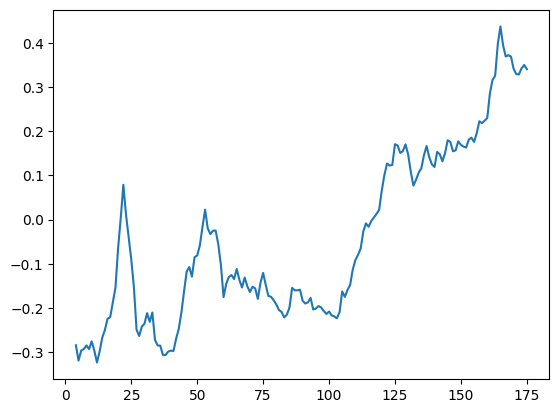

In [168]:
matplotlib.pyplot.plot(hprice["t"],hprice["gRHPI"])

***
## Time Trend and Seasonality

Consider the following model for house price growth:
$$\log(\textit{RHPI}_t) = \beta_0 + \beta_1 t + \delta_1 Q2 + \delta_2 Q3 + \delta_3 Q4 + u_t$$

- $t = 0, 1, 2, \ldots$ is the time index you created in (1.2)
- Q2, Q3, Q4 are dummy variables that equals to 1 in the second, third, and fourth quarter, respectively. Otherwise, they are equal to 0. 

#### 2.1 Estimate the model

In [169]:
model_trend = smf.ols(formula = "logRHPI ~ t + C(Quarter)", data = hprice).fit()

#### 2.2 Get the estimation results

In [170]:
print(model_trend.summary())

                            OLS Regression Results                            
Dep. Variable:                logRHPI   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     245.2
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.10e-69
Time:                        16:34:46   Log-Likelihood:                 96.886
No. Observations:                 176   AIC:                            -183.8
Df Residuals:                     171   BIC:                            -167.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.9058      0.028  

#### 2.3 What is the benchmark (base period) in this model?

#### 2.4 At 5% significance level, is there a statistically significant time trend?

#### 2.5 At 5% significance level, would you conclude that house price growth exhibits seasonality at quarterly frequency?

***
## Autoregressive Process of Order 1

Consider a house price model with AR(1) specification:
$$\log(\textit{RHPI}_t) = \beta_0 + \beta_1 t + \beta_2 \log(\textit{RHPI}_{t-4}) + \delta_1 Q2 + \delta_2 Q3 + \delta_3 Q4 + u_t$$

#### 3.1 Estimate the model

In [171]:
model_ar1 = smf.ols(formula = "logRHPI ~ t + C(Quarter) + logRHPI_4", data = hprice).fit()


#### 3.2 Get the estimation results

In [172]:
print(model_ar1.summary())

                            OLS Regression Results                            
Dep. Variable:                logRHPI   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     700.3
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          1.45e-109
Time:                        16:34:46   Log-Likelihood:                 197.49
No. Observations:                 172   AIC:                            -383.0
Df Residuals:                     166   BIC:                            -364.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -7.9603      0.610  

#### 3.3 At 5% significance level, what would you conclude about $\beta_2$?

#### 3.4 Does the AR(1) process have weak dependence?

Yes! Bc $\beta_1 < 1


#### 3.5 Is the time trend still significant? Why or why not?

***
## Complete Model with other Exogenous Regressors

Consider a house price model with AR(1) specification and other exogenous regressors:
$$\log(\textit{RHPI}_t) = \beta_0 + \beta_1 t + \beta_2 \log(\textit{RHPI}_{t-4}) + \beta_3 \textit{UE}_t + \beta_4 \log(\textit{RPDI}_t) + \delta_1 Q2 + \delta_2 Q3 + \delta_3 Q4 + u_t$$

#### 4.1 Estimate the model

In [173]:
model_final = smf.ols(formula = "logRHPI ~ t + C(Quarter) + logRHPI_4 + UE + logRPDI",data = hprice).fit()
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                logRHPI   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     615.7
Date:                Tue, 08 Apr 2025   Prob (F-statistic):          3.21e-114
Time:                        16:34:46   Log-Likelihood:                 215.63
No. Observations:                 172   AIC:                            -415.3
Df Residuals:                     164   BIC:                            -390.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -9.0040      0.613  

#### 4.2 Get the estimation results

#### 4.3 How would you interpret $\beta_3$? (Be careful on how unemployment rate is reported in the data set)

#### 4.4 At 5% significance level, what would you conclude about $\beta_3$?

#### 4.5 Explain why the AR(1) dependence ($\beta_2$) is weakened, when compare with your results in Question 3.

***
## References
- Jeffrey M. Wooldridge (2019). "Introductory Econometrics: A Modern Approach, 7e" Chapter 11.
    
- The pandas development team (2020). "[pandas-dev/pandas: Pandas](https://pandas.pydata.org/)." Zenodo.
    
- Seabold, Skipper, and Josef Perktold (2010). "[statsmodels: Econometric and statistical modeling with python](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html)." Proceedings of the 9th Python in Science Conference.